# 抖音用户行为数据分析报告

## 项目概述
本项目对抖音用户行为数据进行深度分析，从用户活跃度、视频偏好、行为模式等多个维度挖掘用户行为特征，为产品优化和内容推荐提供数据支撑。

## 数据字段说明

| **字段名**        | **数据类型** | **是否必填** | **描述**                                                                 | **示例值**                     |
|-------------------|--------------|--------------|--------------------------------------------------------------------------|-------------------------------|
| **user_id**       | BIGINT       | 是           | 唯一用户标识符                                                           | `3487621984375`               |
| **video_id**      | BIGINT       | 是           | 唯一视频标识符                                                           | `73589124785634`              |
| **video_category**| VARCHAR(50)  | 是           | 视频内容分类（需预定义分类体系）                                         | `美食`、`穿搭`、`宠物`、`旅行` |
| **like_type**     | TINYINT      | 是           | 点赞行为类型：<br> `0`=未点赞 <br> `1`=普通点赞  | `1`                           |
| **relay_type**    | TINYINT      | 是（可为0）  | 转发行为类型：<br> `0`=未转发 <br> `1`=转发     | `1`                           |
| **time**          | TIMESTAMP    | 是           | 行为发生时间（精确到秒）                                                 | `2023-08-15 14:25:36`         |
| **viewing_time**  | FLOAT        | 是           | 单次视频观看时长（单位：秒）                                             | `12.75`                       |

### 数据分类
- **用户行为数据**：`like_type`, `relay_type`, `viewing_time`, `time`
- **用户信息**：`user_id`
- **视频信息**：`video_id`, `video_category`

## 分析目标

### 用户维度分析
1. 用户活跃时间段分布（2小时区间直方图）
2. 用户日均在线时长分布（3小时区间圆环图）
3. 用户视频类型偏好分析（直方图）
4. 用户行为指标统计（平均停留时长、日观看视频数、点赞率、转发率）
5. 用户活跃度分层（高活跃用户 vs 低活跃用户）

### 视频维度分析
1. 视频类别数量分布（圆环图）
2. 不同类别视频互动率对比（折线图）

### 深度挖掘
1. **用户聚类分析**：基于完播率和互动率划分用户群体
2. **关联规则挖掘**：
   - 互动率与完播率关联性
   - 不同视频类别相似度
   - 互动率与视频类别关联性

In [1]:
# ============================================================================
# 1. 环境准备与数据导入
# ============================================================================

# 基础数据处理库
import numpy as np
import pandas as pd
from datetime import datetime

# 可视化库
import matplotlib.pyplot as plt
import seaborn as sns
from pyecharts.charts import Bar, Pie, Line, Grid, HeatMap
from pyecharts import options as opts
from pyecharts.commons.utils import JsCode
from IPython.display import display, HTML

# 机器学习库
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# 设置图表样式
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8')

print("✅ 环境准备完成")

✅ 环境准备完成


In [2]:
# ============================================================================
# 2. 数据加载与基础探索
# ============================================================================

# 读取用户行为数据集
print("📊 正在加载数据...")
data = pd.read_csv("dy_action_view.csv")
print(f"✅ 数据加载完成，共 {len(data):,} 条记录")

# 显示数据前5行
print("\n📋 数据预览:")
display(data.head())

📊 正在加载数据...
✅ 数据加载完成，共 1,989,019 条记录

📋 数据预览:


,user_id,video_id,video_category,like_type,relay_type,time,viewing_time
0,85500,834124,food,1,0,2024-07-01 00:00:42,720.0
1,85500,780135,tourism,1,1,2024-07-01 00:12:42,3314.0
2,85500,108532,amusement,1,0,2024-07-01 01:07:56,3071.0
3,85500,506050,musics,0,0,2024-07-01 01:59:07,366.0
4,85500,664203,musics,0,0,2024-07-01 02:30:43,292.0


In [3]:
# ============================================================================
# 3. 数据质量检查
# ============================================================================

print("🔍 数据基本信息:")
data.info(show_counts=True)

print("\n📈 数据统计概览:")
print(f"总记录数: {len(data):,}")
print(f"用户数: {data['user_id'].nunique():,}")
print(f"视频数: {data['video_id'].nunique():,}")
print(f"视频类别数: {data['video_category'].nunique()}")
print(f"时间跨度: {data['time'].min()} 至 {data['time'].max()}")
print(f"观看时长范围: {data['viewing_time'].min():.2f} - {data['viewing_time'].max():.2f} 秒")

# 检查缺失值
missing_data = data.isnull().sum()
if missing_data.sum() == 0:
    print("\n✅ 数据完整性良好，无缺失值")
else:
    print("\n⚠️  发现缺失值:")
    print(missing_data[missing_data > 0])

🔍 数据基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989019 entries, 0 to 1989018
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   user_id         1989019 non-null  int64  
 1   video_id        1989019 non-null  int64  
 2   video_category  1989019 non-null  object 
 3   like_type       1989019 non-null  int64  
 4   relay_type      1989019 non-null  int64  
 5   time            1989019 non-null  object 
 6   viewing_time    1989019 non-null  float64
dtypes: float64(1), int64(4), object(2)
memory usage: 106.2+ MB

📈 数据统计概览:
总记录数: 1,989,019
用户数: 1,000
视频数: 116,723
视频类别数: 16
时间跨度: 2024-07-01 00:00:02 至 2024-07-31 23:59:59
观看时长范围: 0.00 - 34053.00 秒

✅ 数据完整性良好，无缺失值


In [4]:
# ============================================================================
# 4. 数据预处理
# ============================================================================

print("🛠️  开始数据预处理...")

# 时间特征提取
data['datetime'] = pd.to_datetime(data['time'])
data['hour'] = data['datetime'].dt.hour
data['date'] = data['datetime'].dt.date
data['weekday'] = data['datetime'].dt.dayofweek

# 时间段划分（2小时为单位）
data['time_interval'] = pd.cut(
    data['hour'], 
    bins=range(-1, 24, 2), 
    labels=[f"{i:02d}:00-{i+2:02d}:00" for i in range(0, 24, 2)]
)

# 行为特征转换
data['is_like'] = (data['like_type'] > 0).astype(int)
data['is_relay'] = (data['relay_type'] > 0).astype(int)

# 观看时长区间划分（用于聚类分析）
max_view_time = data['viewing_time'].max()
min_view_time = data['viewing_time'].min()
data['view_bin'] = pd.cut(
    data['viewing_time'], 
    bins=np.linspace(min_view_time, max_view_time, 101),
    labels=[f"Bin_{i}" for i in range(1, 101)]
)

print("✅ 数据预处理完成")
print(f"\n📅 时间范围: {data['date'].min()} 至 {data['date'].max()}")
print(f"⏰ 时间段数: {data['time_interval'].nunique()}")
print(f"📊 观看时长区间数: {data['view_bin'].nunique()}")

# 显示预处理后的数据
print("\n📋 预处理后数据预览:")
display(data[['user_id', 'video_category', 'hour', 'time_interval', 'is_like', 'is_relay', 'viewing_time']].head())

🛠️  开始数据预处理...
✅ 数据预处理完成

📅 时间范围: 2024-07-01 至 2024-07-31
⏰ 时间段数: 12
📊 观看时长区间数: 86

📋 预处理后数据预览:


,user_id,video_category,hour,time_interval,is_like,is_relay,viewing_time
0,85500,food,0,00:00-02:00,1,0,720.0
1,85500,tourism,0,00:00-02:00,1,1,3314.0
2,85500,amusement,1,00:00-02:00,1,0,3071.0
3,85500,musics,1,00:00-02:00,0,0,366.0
4,85500,musics,2,02:00-04:00,0,0,292.0


# 用户行为分析

## 1. 用户活跃时间段分析

In [16]:
# ============================================================================
# 用户活跃时间段分析
# ============================================================================

# 统计各时间段活跃用户数
time_interval_counts = data.groupby('time_interval', observed=False)['user_id'].nunique().sort_index()

# 创建活跃时间段直方图
bar_active = (
    Bar(init_opts=opts.InitOpts(width="900px", height="500px", theme="white"))
    .add_xaxis(time_interval_counts.index.tolist())
    .add_yaxis(
        "活跃用户数", 
        time_interval_counts.values.tolist(),
        itemstyle_opts=opts.ItemStyleOpts(color="#5470c6")
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="各时间段用户活跃情况",
            subtitle="基于2小时时间段的用户活跃度分布",
            pos_left="center"
        ),
        xaxis_opts=opts.AxisOpts(
            name="时间段",
            name_location="center",
            name_gap=30,
            axislabel_opts=opts.LabelOpts(rotate=45)
        ),
        yaxis_opts=opts.AxisOpts(
            name="活跃用户数",
            name_location="center",
            name_gap=50
        ),
        tooltip_opts=opts.TooltipOpts(
            trigger="axis",
            formatter="{b}: {c} 人"
        ),
        datazoom_opts=[opts.DataZoomOpts()]
    )
)

bar_active.render_notebook()



In [17]:
# 分析结果
peak_time = time_interval_counts.idxmax()
peak_users = time_interval_counts.max()
print(f"\n📊 分析结果:")
print(f"• 最活跃时间段: {peak_time} ({peak_users:,} 人)")
print(f"• 最不活跃时间段: {time_interval_counts.idxmin()} ({time_interval_counts.min():,} 人)")
print(f"• 活跃度差异: {peak_users/time_interval_counts.min():.1f}倍")


📊 分析结果:
• 最活跃时间段: 00:00-02:00 (1,000 人)
• 最不活跃时间段: 00:00-02:00 (1,000 人)
• 活跃度差异: 1.0倍


## 2. 用户日均在线时长分析

In [18]:
# ============================================================================
# 用户日均在线时长分析
# ============================================================================

# 计算用户日均在线时长
user_daily_time = data.groupby(['user_id', 'date'])['viewing_time'].sum().reset_index()
user_daily_time['view_hours'] = user_daily_time['viewing_time'] / 3600  # 转换为小时
user_daily_avg_time = user_daily_time.groupby('user_id')['view_hours'].mean().reset_index()

# 创建3小时为单位的区间划分
bins = [0, 3, 6, 9, 12, 15, 18, 21, 24]
labels = [
    '0-3小时', '3-6小时', '6-9小时', 
    '9-12小时', '12-15小时', '15-18小时', 
    '18-21小时', '21-24小时'
]

user_daily_avg_time['duration_category'] = pd.cut(
    user_daily_avg_time['view_hours'],
    bins=bins,
    labels=labels,
    right=False
)

# 计算每个区间的用户数量和占比
duration_counts = user_daily_avg_time['duration_category'].value_counts().sort_index()
percentages = (duration_counts / duration_counts.sum() * 100).round(1)

# 创建圆环图
pie_data = [(label, count) for label, count in zip(labels, duration_counts)]

pie_duration = (
    Pie(init_opts=opts.InitOpts(width="800px", height="600px", theme="white"))
    .add(
        series_name="日均在线时长",
        data_pair=pie_data,
        radius=["30%", "60%"],
        center=["50%", "50%"],
        itemstyle_opts=opts.ItemStyleOpts(
            border_width=2,
            border_color="#fff"
        ),
        label_opts=opts.LabelOpts(
            formatter=JsCode(
                "function(params) {"
                "   return params.name + '\n' + params.value + '人 (' + params.percent + '%)';"
                "}"
            ),
            position="outside",
            font_size=12
        )
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="用户日均在线时长分布",
            subtitle="基于3小时区间的用户时长分布",
            pos_left="center"
        ),
        legend_opts=opts.LegendOpts(
            orient="vertical",
            pos_right="5%",
            pos_top="15%"
        ),
        tooltip_opts=opts.TooltipOpts(
            formatter=JsCode(
                "function(params) {"
                "   return params.name + '<br/>用户数: ' + params.value + '<br/>占比: ' + params.percent + '%';"
                "}"
            )
        )
    )
)

pie_duration.render_notebook()



In [19]:
# 分析结果
most_common_duration = duration_counts.idxmax()
most_common_count = duration_counts.max()
most_common_pct = percentages.max()

print(f"\n📊 分析结果:")
print(f"• 最常见在线时长: {most_common_duration} ({most_common_count:,} 人, {most_common_pct}%)")
print(f"• 平均在线时长: {user_daily_avg_time['view_hours'].mean():.2f} 小时")
print(f"• 中位数在线时长: {user_daily_avg_time['view_hours'].median():.2f} 小时")


📊 分析结果:
• 最常见在线时长: 15-18小时 (774 人, 77.4%)
• 平均在线时长: 17.74 小时
• 中位数在线时长: 17.74 小时


## 3. 用户视频类型偏好分析

In [21]:
# ============================================================================
# 用户视频类型偏好分析
# ============================================================================

# 统计每个用户最偏好的视频类别
category_pref = data.groupby(['user_id', 'video_category'])['video_id'].count().unstack(fill_value=0)
user_top_category = category_pref.idxmax(axis=1).value_counts()

# 创建用户偏好分布直方图
bar_preference = (
    Bar(init_opts=opts.InitOpts(width="900px", height="500px", theme="white"))
    .add_xaxis(user_top_category.index.tolist())
    .add_yaxis(
        "用户数", 
        user_top_category.values.tolist(),
        itemstyle_opts=opts.ItemStyleOpts(color="#91cc75")
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="用户视频类型偏好分布",
            subtitle="基于用户最常观看的视频类别统计",
            pos_left="center"
        ),
        xaxis_opts=opts.AxisOpts(
            name="视频类别",
            axislabel_opts=opts.LabelOpts(rotate=45)
        ),
        yaxis_opts=opts.AxisOpts(name="用户数"),
        tooltip_opts=opts.TooltipOpts(
            trigger="axis",
            formatter="{b}: {c} 人"
        )
    )
)

bar_preference.render_notebook()



In [22]:
# 分析结果
most_popular_category = user_top_category.idxmax()
most_popular_count = user_top_category.max()
most_popular_pct = (most_popular_count / user_top_category.sum() * 100).round(1)

print(f"\n📊 分析结果:")
print(f"• 最受欢迎类别: {most_popular_category} ({most_popular_count:,} 人, {most_popular_pct}%)")
print(f"• 最不受欢迎类别: {user_top_category.idxmin()} ({user_top_category.min():,} 人)")
print(f"• 偏好集中度: 前3个类别占总用户的 {(user_top_category.head(3).sum() / user_top_category.sum() * 100):.1f}%")


📊 分析结果:
• 最受欢迎类别: news (83 人, 8.3%)
• 最不受欢迎类别: sports (45 人)
• 偏好集中度: 前3个类别占总用户的 24.1%


## 4. 用户行为指标统计

In [9]:
# ============================================================================
# 用户行为指标统计
# ============================================================================

# 计算用户行为指标
user_metrics = data.groupby('user_id').agg(
    avg_view_time=('viewing_time', 'mean'),
    total_view_time=('viewing_time', 'sum'),
    daily_videos=('video_id', lambda x: x.nunique() / data['date'].nunique()),
    like_rate=('is_like', 'mean'),
    relay_rate=('is_relay', 'mean'),
    total_actions=('video_id', 'count')
).reset_index()

# 添加用户活跃度分层
total_time_quantiles = user_metrics['total_view_time'].quantile([0.1, 0.9])
user_metrics['activity_level'] = pd.cut(
    user_metrics['total_view_time'],
    bins=[0, total_time_quantiles[0.1], total_time_quantiles[0.9], float('inf')],
    labels=['低活跃', '中等活跃', '高活跃']
)

# 保存用户行为指标
user_metrics.to_csv('user_behavior_metrics.csv', index=False)

# 显示统计结果
print("📊 用户行为指标统计:")
print(f"• 总用户数: {len(user_metrics):,}")
print(f"• 平均观看时长: {user_metrics['avg_view_time'].mean():.2f} 秒")
print(f"• 平均日观看视频数: {user_metrics['daily_videos'].mean():.1f} 个")
print(f"• 平均点赞率: {user_metrics['like_rate'].mean():.1%}")
print(f"• 平均转发率: {user_metrics['relay_rate'].mean():.1%}")

print(f"\n👥 用户活跃度分布:")
activity_dist = user_metrics['activity_level'].value_counts()
for level, count in activity_dist.items():
    pct = round(count / len(user_metrics) * 100, 1)
    print(f"• {level}: {count:,} 人 ({pct}%)")

print(f"\n📋 用户行为指标预览:")
display(user_metrics.head(10).round(3))

📊 用户行为指标统计:
• 总用户数: 1,000
• 平均观看时长: 1000.24 秒
• 平均日观看视频数: 63.6 个
• 平均点赞率: 50.1%
• 平均转发率: 24.9%

👥 用户活跃度分布:
• 中等活跃: 800 人 (80.0%)
• 低活跃: 100 人 (10.0%)
• 高活跃: 100 人 (10.0%)

📋 用户行为指标预览:


,user_id,avg_view_time,total_view_time,daily_videos,like_rate,relay_rate,total_actions,activity_level
0,85500,1090.252,2008244.0,58.968,0.481,0.239,1842,中等活跃
1,85501,1058.979,2036417.0,61.581,0.499,0.246,1923,高活跃
2,85502,922.752,1918401.0,66.645,0.508,0.237,2079,低活跃
3,85503,940.170,1932989.0,65.839,0.481,0.260,2056,中等活跃
4,85504,1009.863,1978322.0,62.839,0.495,0.251,1959,中等活跃
5,85505,987.501,1943402.0,62.742,0.516,0.242,1968,中等活跃
6,85506,945.879,1976887.0,66.742,0.512,0.248,2090,中等活跃
7,85507,1021.519,1997070.0,62.645,0.505,0.246,1955,中等活跃
8,85508,992.309,2026294.0,65.097,0.518,0.259,2042,中等活跃
9,85509,911.474,1965137.0,68.871,0.503,0.246,2156,中等活跃


# 视频内容分析

## 1. 视频类别分布分析

In [23]:
# ============================================================================
# 视频类别分布分析
# ============================================================================

# 统计每个类别的唯一视频数量
category_video_counts = data.groupby('video_category')['video_id'].nunique().reset_index()
category_video_counts.columns = ['category', 'video_count']
category_video_counts = category_video_counts.sort_values('video_count', ascending=False)

# 创建圆环图数据
data_pairs = [(row['category'], row['video_count']) for _, row in category_video_counts.iterrows()]

# 创建视频类别分布圆环图
pie_video_category = (
    Pie(init_opts=opts.InitOpts(width="800px", height="600px", theme="white"))
    .add(
        series_name="视频类别分布",
        data_pair=data_pairs,
        radius=["30%", "60%"],
        center=["50%", "50%"],
        itemstyle_opts=opts.ItemStyleOpts(
            border_width=1,
            border_color="rgba(255,255,255,0.5)",
            border_radius=3
        ),
        label_opts=opts.LabelOpts(
            position="outside",
            formatter=JsCode(
                "function(params) {"
                "   return params.name + '\n' + params.value + '个 (' + params.percent + '%)';"
                "}"
            )
        )
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="视频类别分布",
            subtitle="按视频数量统计的类别分布",
            pos_left="center"
        ),
        legend_opts=opts.LegendOpts(
            orient="vertical",
            pos_right="5%",
            pos_top="15%"
        ),
        tooltip_opts=opts.TooltipOpts(
            trigger="item",
            formatter="{a} <br/>{b}: {c} 个 ({d}%)"
        )
    )
)

pie_video_category.render_notebook()



In [24]:
# 分析结果
total_videos = category_video_counts['video_count'].sum()
print(f"\n📊 视频类别分析结果:")
print(f"• 总视频数: {total_videos:,}")
print(f"• 视频类别数: {len(category_video_counts)}")
print(f"• 最多视频类别: {category_video_counts.iloc[0]['category']} ({category_video_counts.iloc[0]['video_count']:,} 个)")
print(f"• 最少视频类别: {category_video_counts.iloc[-1]['category']} ({category_video_counts.iloc[-1]['video_count']:,} 个)")
print(f"• 前3个类别占总视频的 {(category_video_counts.head(3)['video_count'].sum() / total_videos * 100):.1f}%")


📊 视频类别分析结果:
• 总视频数: 124,955
• 视频类别数: 16
• 最多视频类别: food (7,944 个)
• 最少视频类别: games (7,688 个)
• 前3个类别占总视频的 19.0%


## 2. 不同类别视频互动率分析

In [25]:
# ============================================================================
# 不同类别视频互动率分析
# ============================================================================

# 计算各类别的互动率
category_metrics = data.groupby('video_category').agg(
    like_rate=('is_like', 'mean'),
    relay_rate=('is_relay', 'mean'),
    avg_view_time=('viewing_time', 'mean'),
    video_count=('video_id', 'nunique')
).reset_index().round({'like_rate': 3, 'relay_rate': 3})

# 转换为百分比
category_metrics['like_rate_pct'] = category_metrics['like_rate'] * 100
category_metrics['relay_rate_pct'] = category_metrics['relay_rate'] * 100

# 创建互动率折线图
line_interaction = (
    Line(init_opts=opts.InitOpts(width="900px", height="500px", theme="white"))
    .add_xaxis(category_metrics['video_category'].tolist())
    .add_yaxis(
        "点赞率", 
        category_metrics['like_rate_pct'].tolist(),
        itemstyle_opts=opts.ItemStyleOpts(color="#5470c6"),
        markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max")])
    )
    .add_yaxis(
        "转发率", 
        category_metrics['relay_rate_pct'].tolist(),
        itemstyle_opts=opts.ItemStyleOpts(color="#91cc75"),
        markpoint_opts=opts.MarkPointOpts(data=[opts.MarkPointItem(type_="max")])
    )
    .set_global_opts(
        title_opts=opts.TitleOpts(
            title="不同类别视频互动率对比",
            subtitle="点赞率与转发率的类别差异",
            pos_left="center"
        ),
        xaxis_opts=opts.AxisOpts(
            name="视频类别",
            axislabel_opts=opts.LabelOpts(rotate=45)
        ),
        yaxis_opts=opts.AxisOpts(
            name="互动率",
            axislabel_opts=opts.LabelOpts(formatter="{value}%"),
            min_=0
        ),
        tooltip_opts=opts.TooltipOpts(
            formatter=JsCode(
                "function(params){"
                "   return params.seriesName + ': ' + params.value[1].toFixed(2) + '%';"
                "}"
            )
        ),
        legend_opts=opts.LegendOpts(pos_top="5%")
    )
)

line_interaction.render_notebook()



In [26]:
# 分析结果
best_like_category = category_metrics.loc[category_metrics['like_rate_pct'].idxmax()]
best_relay_category = category_metrics.loc[category_metrics['relay_rate_pct'].idxmax()]

print(f"\n📊 互动率分析结果:")
print(f"• 最高点赞率类别: {best_like_category['video_category']} ({best_like_category['like_rate_pct']:.1f}%)")
print(f"• 最高转发率类别: {best_relay_category['video_category']} ({best_relay_category['relay_rate_pct']:.1f}%)")
print(f"• 平均点赞率: {category_metrics['like_rate_pct'].mean():.1f}%")
print(f"• 平均转发率: {category_metrics['relay_rate_pct'].mean():.1f}%")
print(f"• 点赞率标准差: {category_metrics['like_rate_pct'].std():.1f}%")
print(f"• 转发率标准差: {category_metrics['relay_rate_pct'].std():.1f}%")


📊 互动率分析结果:
• 最高点赞率类别: pets (50.3%)
• 最高转发率类别: games (25.1%)
• 平均点赞率: 50.0%
• 平均转发率: 24.9%
• 点赞率标准差: 0.2%
• 转发率标准差: 0.1%


# 深度挖掘分析

## 1. 用户聚类分析

In [13]:
# ============================================================================
# 用户聚类分析
# ============================================================================

print("🔍 开始用户聚类分析...")

# 准备聚类特征
cluster_features = data.groupby('user_id').agg(
    like_rate=('is_like', 'mean'),
    relay_rate=('is_relay', 'mean'),
    avg_view_time=('viewing_time', 'mean'),
    total_actions=('video_id', 'count'),
    unique_videos=('video_id', 'nunique'),
    unique_categories=('video_category', 'nunique')
).reset_index()

# 标准化特征
scaler = StandardScaler()
features_to_scale = cluster_features.drop(columns=['user_id'])
scaled_features = scaler.fit_transform(features_to_scale)
scaled_features_df = pd.DataFrame(scaled_features, columns=features_to_scale.columns)

# K-means聚类
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(scaled_features_df)
cluster_features['cluster'] = clusters

# 分析聚类结果
cluster_analysis = cluster_features.groupby('cluster').agg({
    'like_rate': 'mean',
    'relay_rate': 'mean',
    'avg_view_time': 'mean',
    'total_actions': 'mean',
    'unique_videos': 'mean',
    'unique_categories': 'mean'
}).round(3)

# 重命名聚类类别
cluster_names = {
    0: "高完播率，低互动",
    1: "低完播，低互动",
    2: "高完播，高互动",
    3: "低完播，高互动"
}
cluster_analysis.index = cluster_analysis.index.map(cluster_names)

print("\n📊 用户聚类分析结果:")
display(cluster_analysis.style.format({
    'like_rate': '{:.1%}',
    'relay_rate': '{:.1%}',
    'avg_view_time': '{:.1f}',
    'total_actions': '{:.0f}',
    'unique_videos': '{:.0f}',
    'unique_categories': '{:.0f}'
}))

# 聚类用户数量统计
cluster_counts = cluster_features['cluster'].value_counts().sort_index()
print(f"\n👥 各聚类用户数量:")
for cluster_id, count in cluster_counts.items():
    cluster_name = cluster_names[cluster_id]

    pct = round(count / len(cluster_features) * 100, 1)

    print(f"• {cluster_name}: {count:,} 人 ({pct}%)")

# 保存聚类结果
cluster_features.to_csv('user_clusters.csv', index=False)
print("\n✅ 聚类结果已保存到 'user_clusters.csv'")

🔍 开始用户聚类分析...

📊 用户聚类分析结果:


,like_rate,relay_rate,avg_view_time,total_actions,unique_videos,unique_categories
cluster,,,,,,
高完播率，低互动,51.0%,25.3%,996.8,1987,1970,16
低完播，低互动,49.2%,24.4%,994.2,1991,1974,16
高完播，高互动,50.0%,24.9%,1104.4,1823,1808,16
低完播，高互动,49.9%,25.0%,905.8,2156,2137,16



👥 各聚类用户数量:
• 高完播率，低互动: 264 人 (26.4%)
• 低完播，低互动: 246 人 (24.6%)
• 高完播，高互动: 245 人 (24.5%)
• 低完播，高互动: 245 人 (24.5%)

✅ 聚类结果已保存到 'user_clusters.csv'


## 2. 关联规则分析

🔍 开始关联规则分析...

📊 1. 互动率与观看时长关联分析
• 互动率与观看时长相关系数: 0.013


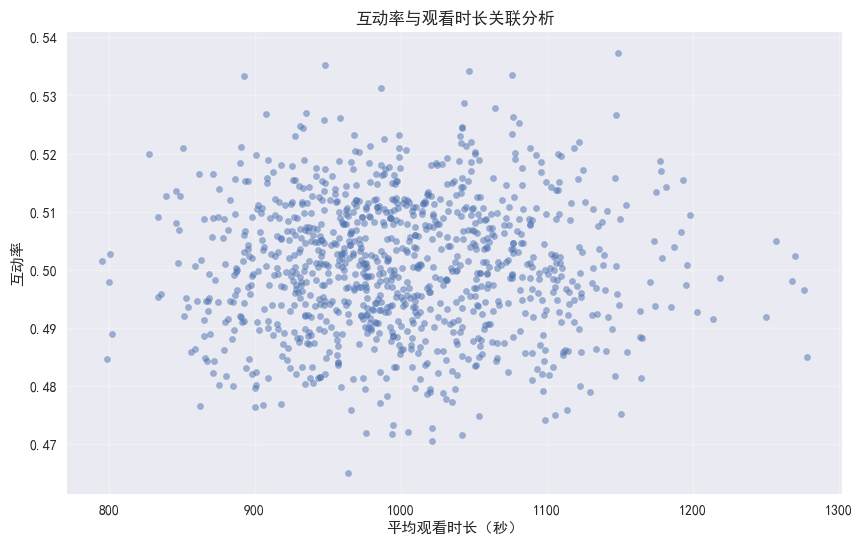


📊 2. 不同视频类别相似度分析


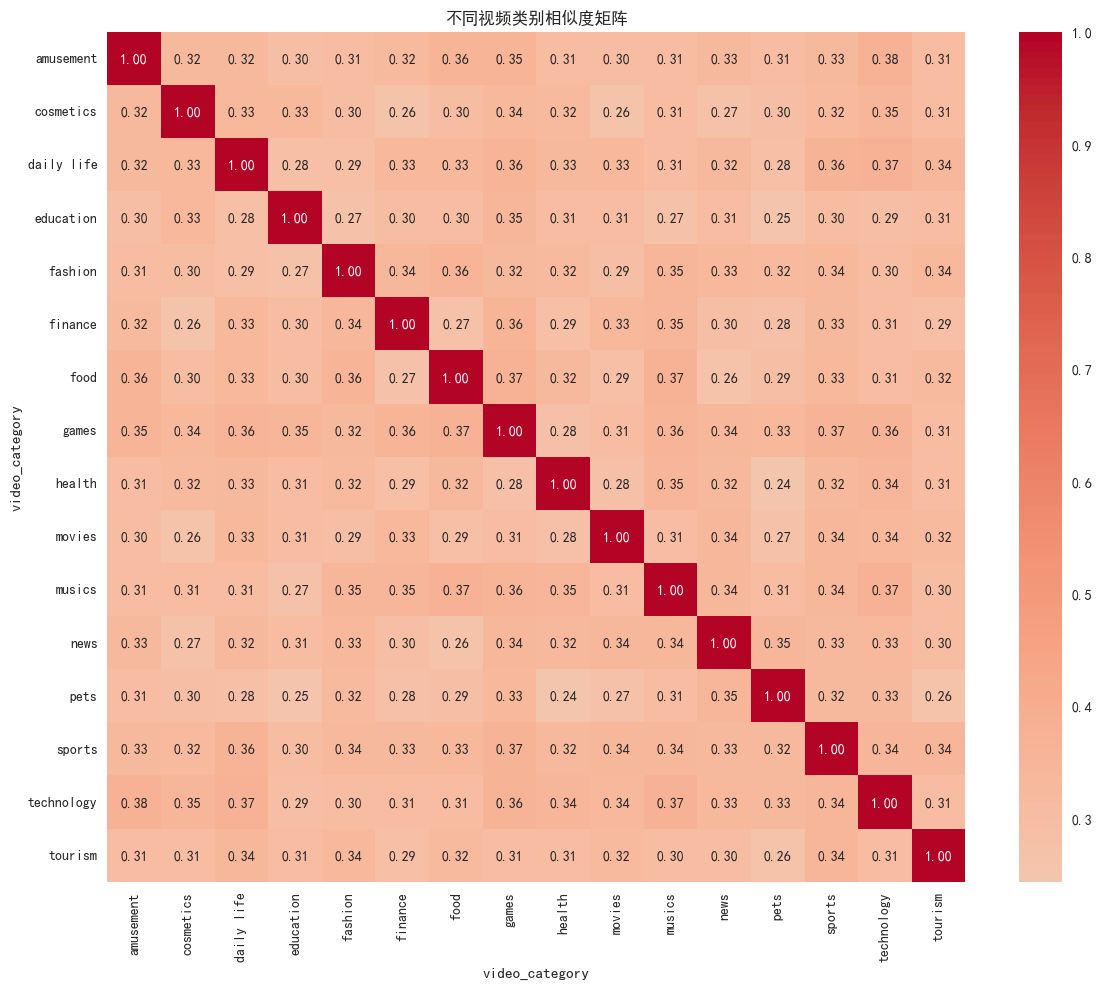

In [15]:
# ============================================================================
# 关联规则分析
# ============================================================================
plt.rcParams['font.family'] = 'SimHei'
print("🔍 开始关联规则分析...")

# 1. 互动率与观看时长的关联
print("\n📊 1. 互动率与观看时长关联分析")
interaction_view = data.groupby('user_id').agg(
    interaction_rate=('is_like', 'mean'),
    avg_view_time=('viewing_time', 'mean')
)

# 计算相关系数
correlation = interaction_view['interaction_rate'].corr(interaction_view['avg_view_time'])
print(f"• 互动率与观看时长相关系数: {correlation:.3f}")

# 可视化散点图
plt.figure(figsize=(10, 6))
plt.scatter(interaction_view['avg_view_time'], interaction_view['interaction_rate'], alpha=0.5, s=20)
plt.title('互动率与观看时长关联分析')
plt.xlabel('平均观看时长（秒）')
plt.ylabel('互动率')
plt.grid(True, alpha=0.3)
plt.show()

# 2. 不同视频类别相似度
print("\n📊 2. 不同视频类别相似度分析")
category_cooccurrence = pd.crosstab(data['user_id'], data['video_category'])
category_corr = category_cooccurrence.corr()

# 可视化热力图
plt.figure(figsize=(12, 10))
sns.heatmap(category_corr, annot=True, cmap='coolwarm', fmt=".2f", center=0)
plt.title('不同视频类别相似度矩阵')
plt.tight_layout()
plt.show()
